# Optimización de Parámetros - XGB

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from modulos.LR.gruas.generals import make_lags
from modulos.DirRec.gruas.optimizer import XGBOptimizer

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Optimizando un solo Producto

## Baseline XGB

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from modulos.LR.gruas.generals import cross_validation_ts_mape_r2, split_data_train, make_timeserie

idArticulo = "filtrodepresio"
ts = df_time[idArticulo].copy()
n_lags = 4
X,y, scaler  = make_timeserie(ts, n_lags)

In [9]:
model = XGBRegressor(max_depth=6, gamma=.01, n_estimators=2,)
model.fit(X, y)
y_fit = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [10]:
from modulos.LR.gruas.generals import cross_validation_ts_mape_r2, split_data_train, make_timeserie
X_train, y_train = split_data_train(X, y, .2)
mse, r2_ = cross_validation_ts_mape_r2(model, X, y , .2)
print(f"MSE: {mse}")
print(f"R2: {r2_}")
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

MSE: 0.06496842156537273
R2: -0.5920132809978105


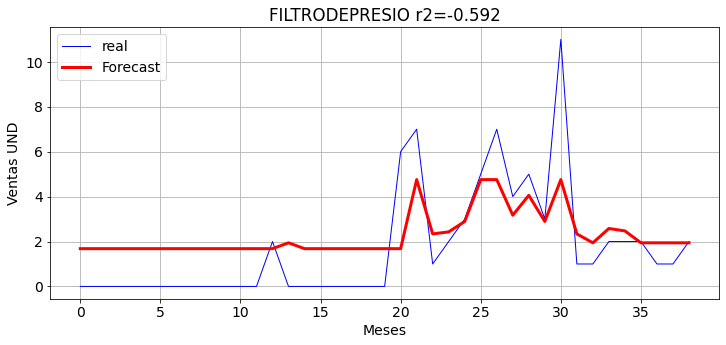

In [11]:
show_results_r2(scaler.inverse_transform(y), scaler.inverse_transform(y_fit),idArticulo, r2_ )


# Optimizar todos los Productos        
        

In [12]:
optimizer = XGBOptimizer(df_time, iterations=200, data_path= DATA_PATH , model='XGB', subpath = 'DirRec')
optimizer.run( chunk_size=2)

/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-define

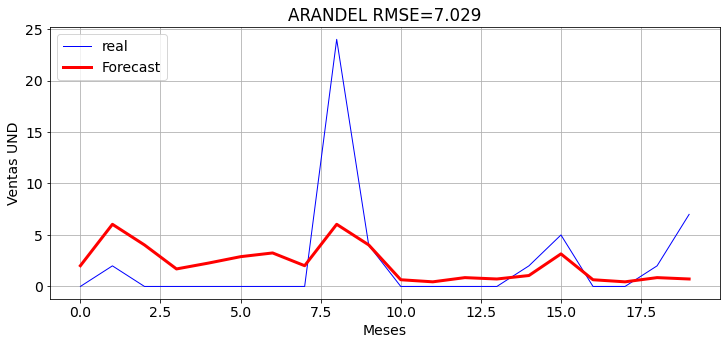

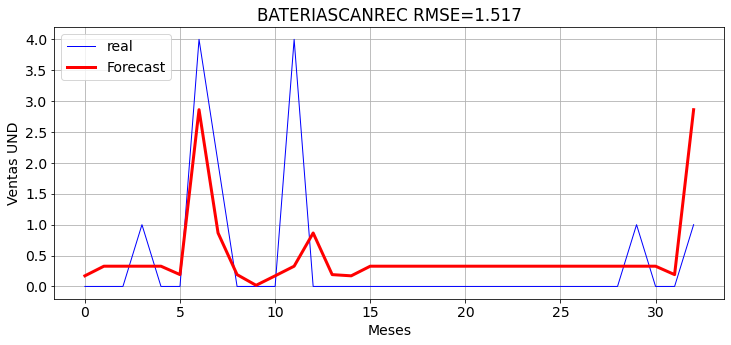

/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


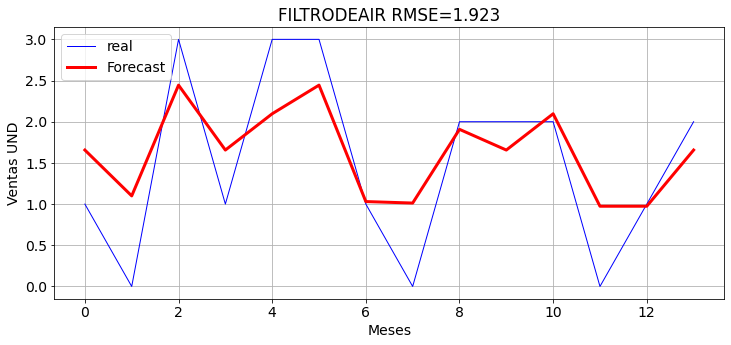

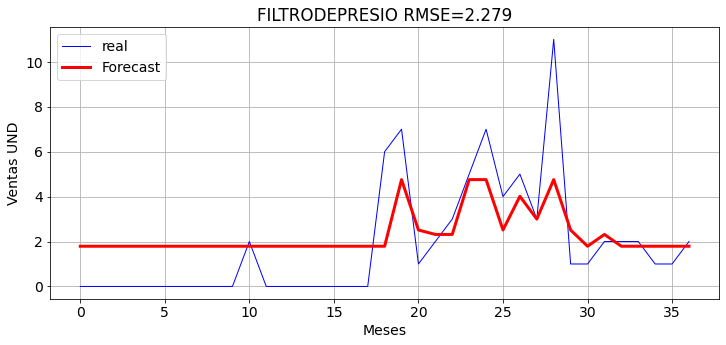

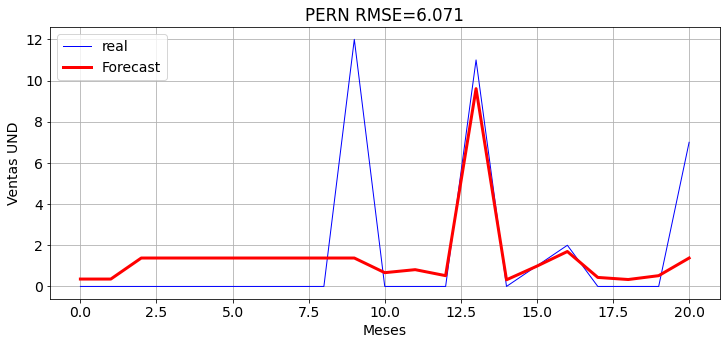

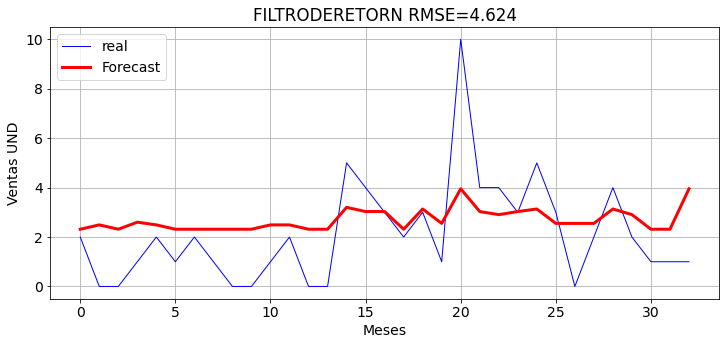

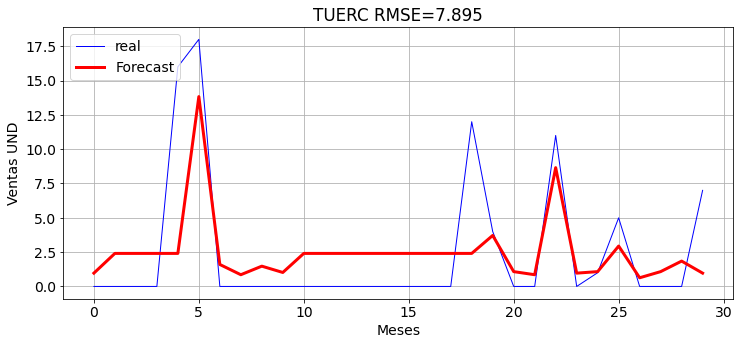

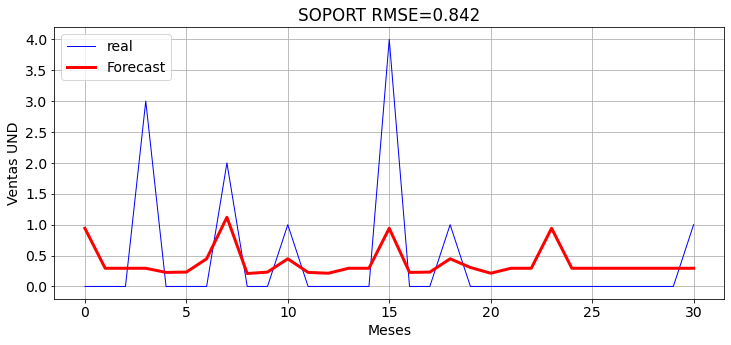

In [13]:
optimizer.print_results()

# Optimizer -  Evolution on time

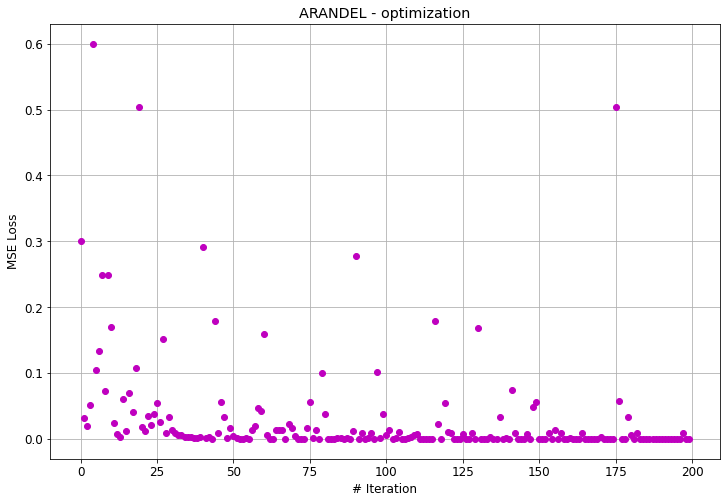

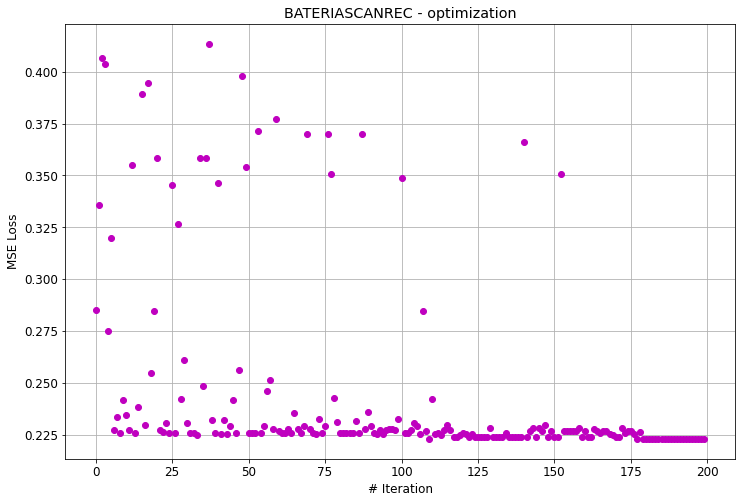

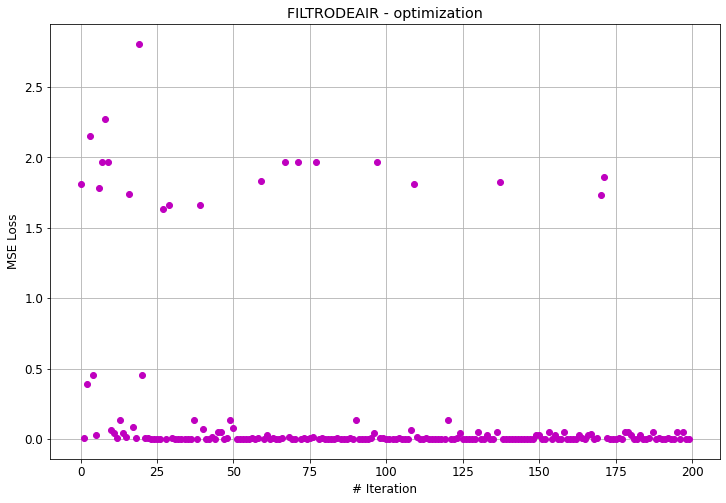

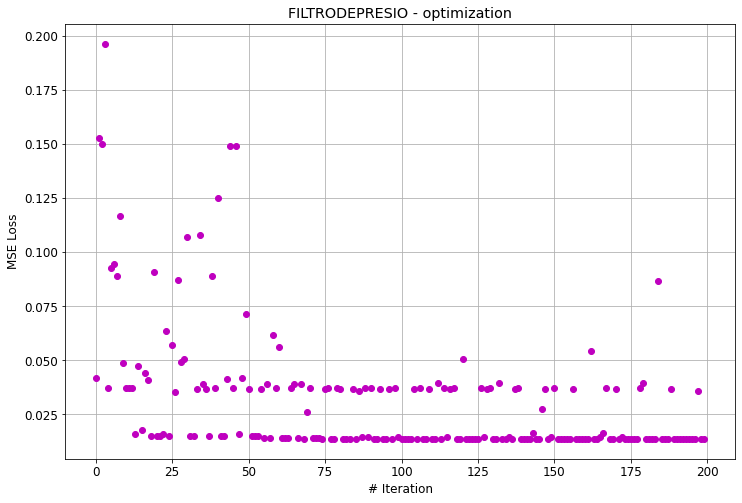

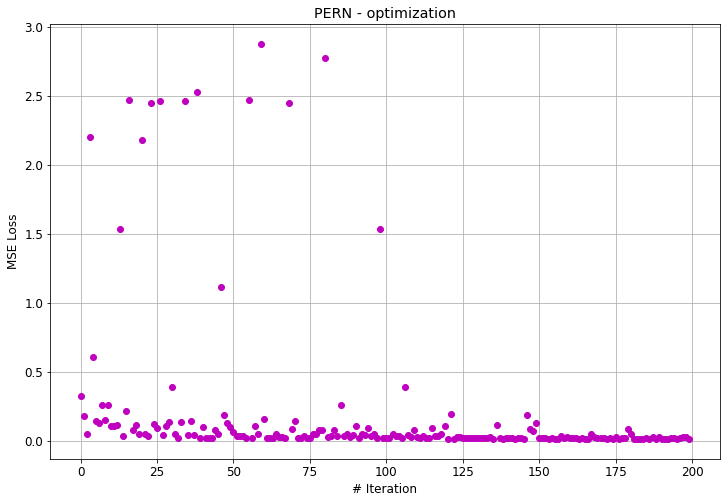

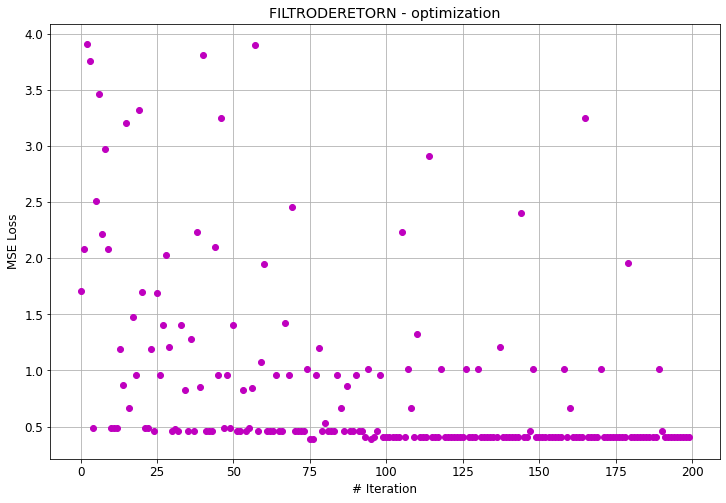

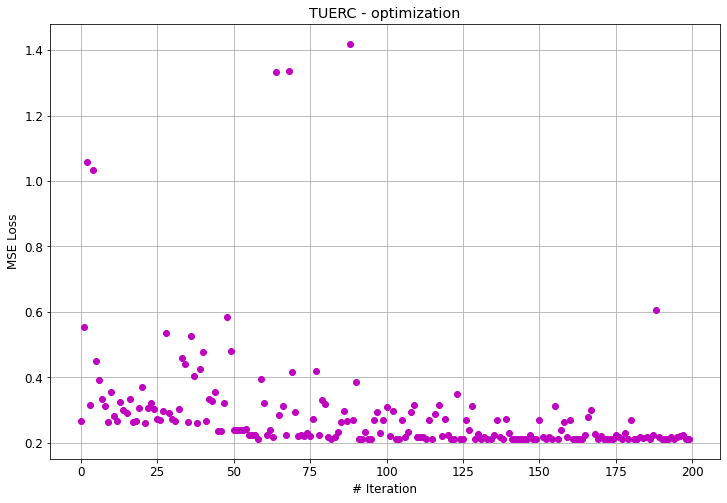

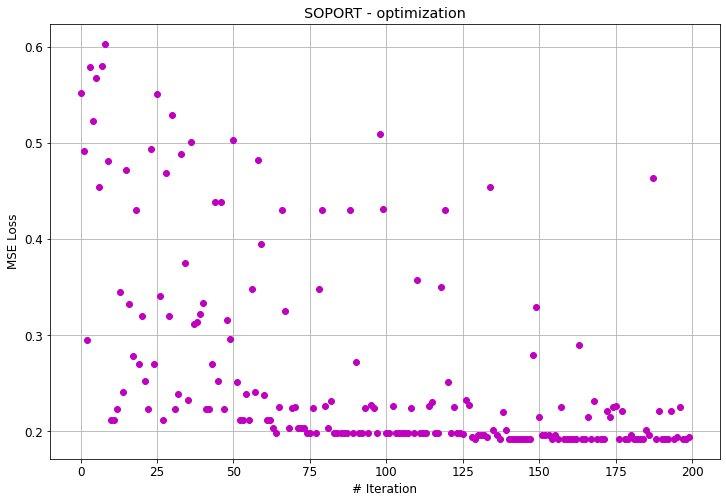

In [14]:
optimizer.print_optimizer_results()

In [15]:
optimizer.results.head()

,idArticulo,hyper,r2_test,mse_test,model
0,arandel,"{'n_lags': 6, 'max_depth': 4, 'random_state': ...",-2.451822,0.713500,XGB
1,bateriascanrec,"{'n_lags': 3, 'max_depth': 2, 'random_state': ...",-4.445380,1.185389,XGB
2,filtrodeair,"{'n_lags': 5, 'max_depth': 4, 'random_state': ...",NaN,0.108929,XGB
3,filtrodepresio,"{'n_lags': 6, 'max_depth': 3, 'random_state': ...",-0.905069,0.070545,XGB
4,pern,"{'n_lags': 5, 'max_depth': 5, 'random_state': ...",-0.378400,1.100408,XGB
